In [60]:
# lets make a transformer
# things to note: colab wont let me use gpu forever, so I will eventually need
# include a save point every e epochs.

import torch
import matplotlib.pyplot as plt

In [48]:
# ok wow I didnt know karpathy just has an endpoint to download the tiny shakespeare set.
# very nice.
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-05-06 23:22:37--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.2’

input.txt.2         100%[===================>]   1.06M  --.-KB/s    in 0.06s   

2023-05-06 23:22:37 (19.2 MB/s) - ‘input.txt.2’ saved [1115394/1115394]



In [49]:
# so lets first take a look at the data, get a feel for it.
with open("input.txt", "r") as f:
  data = f.read()

print("Number of characters: ", len(data))
# print("First 100 characters:\n", data[:100])

# get the dataset vocab
vocab = list(set(data))
print("Size of vocab: ", len(vocab))
print("Vocab: ", vocab)

Number of characters:  1115394
Size of vocab:  65
Vocab:  ['G', 'I', 'f', 'A', 'O', 'K', 'd', 'Y', 'W', 'S', 'x', '.', 'g', 'C', '!', 'B', "'", ';', '-', 'p', 'k', '&', 'Z', 'E', 'm', 'h', ',', '3', '\n', 'U', 'Q', 's', 'z', 'j', 'i', 'N', ' ', 'l', 'D', '?', 'M', 'V', 'v', 'c', 'L', 't', 'R', 'P', 'a', 'n', 'o', 'b', 'X', 'e', 'y', 'T', 'w', 'F', 'J', 'u', 'r', 'q', '$', ':', 'H']


In [50]:
# set up mapping for vocab chars to indices and viceversa
char2idx = {}
idx2char = {}
for i in range(len(vocab)):
  char2idx[vocab[i]] = i
  idx2char[i] = vocab[i]

print("Character to index mapping: ", char2idx)
print("Index to character mapping: ", idx2char)

# weve now got a way to encode a sentence into indices and decode it back into a sentence
def encode_sequence(sequence):
  return [char2idx[char] for char in sequence]

def decode_indices(idx_sequence):
  return [idx2char[i] for i in idx_sequence]

print(encode_sequence("hello bob"))
print(decode_indices(encode_sequence("hello bob")))

# lifted basically from karpathy: convert data into 1 dim tensor for input into model
data_tensor = torch.tensor(encode_sequence(data), dtype=torch.long)
print(data_tensor.shape)

train_size = 0.85
split = int(train_size * len(data))
train_tensor = data_tensor[:split]
test_tensor = data_tensor[split:]

# batch_size = 8
# context_size = 8
# data batching
def batch_data(data, context_size, batch_size):
  # random sampling of data, returns tensors of shape (context_size, batch_size)
  rand_idx = torch.randint(low=0, high=len(data) - context_size, size=(batch_size, ))
  #print(torch.stack([data[:context_size], data[1:1 + context_size]]))
  inputs = torch.stack([data[i:i + context_size] for i in rand_idx])
  targets = torch.stack([data[i + 1: i + context_size + 1] for i in rand_idx])
  return inputs, targets
"""
batch_x, batch_y = batch_data(train_tensor, context_size, batch_size)
#print(batch_x)
#print(batch_y)

# idea of training with context length, each target at time t will be
# conditioned on previous t inputs.
for batch in range(batch_size):
  for cl in range(context_size): # dually iterating over time as char at time t is your target for input of length t.
    curr_context = batch_x[batch, :cl + 1]
    target = batch_y[batch, cl]

    # print(f"Input {curr_context} and target {target}")
"""

Character to index mapping:  {'G': 0, 'I': 1, 'f': 2, 'A': 3, 'O': 4, 'K': 5, 'd': 6, 'Y': 7, 'W': 8, 'S': 9, 'x': 10, '.': 11, 'g': 12, 'C': 13, '!': 14, 'B': 15, "'": 16, ';': 17, '-': 18, 'p': 19, 'k': 20, '&': 21, 'Z': 22, 'E': 23, 'm': 24, 'h': 25, ',': 26, '3': 27, '\n': 28, 'U': 29, 'Q': 30, 's': 31, 'z': 32, 'j': 33, 'i': 34, 'N': 35, ' ': 36, 'l': 37, 'D': 38, '?': 39, 'M': 40, 'V': 41, 'v': 42, 'c': 43, 'L': 44, 't': 45, 'R': 46, 'P': 47, 'a': 48, 'n': 49, 'o': 50, 'b': 51, 'X': 52, 'e': 53, 'y': 54, 'T': 55, 'w': 56, 'F': 57, 'J': 58, 'u': 59, 'r': 60, 'q': 61, '$': 62, ':': 63, 'H': 64}
Index to character mapping:  {0: 'G', 1: 'I', 2: 'f', 3: 'A', 4: 'O', 5: 'K', 6: 'd', 7: 'Y', 8: 'W', 9: 'S', 10: 'x', 11: '.', 12: 'g', 13: 'C', 14: '!', 15: 'B', 16: "'", 17: ';', 18: '-', 19: 'p', 20: 'k', 21: '&', 22: 'Z', 23: 'E', 24: 'm', 25: 'h', 26: ',', 27: '3', 28: '\n', 29: 'U', 30: 'Q', 31: 's', 32: 'z', 33: 'j', 34: 'i', 35: 'N', 36: ' ', 37: 'l', 38: 'D', 39: '?', 40: 'M', 41: 

In [62]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We are using device:", device)

We are using device: cuda


In [56]:
# Bigram model: P[next char | all previous chars] = P[next_char | last char]
class BigramLM(torch.nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    self.embedding = torch.nn.Embedding(vocab_size, vocab_size)

  def forward(self, input_sequence, target_sequence):
    # input_sequence is tensor of indices which map to chars in vocab
    # probs: (batch_size, context_size, vocab_size) : probability of chars
    probs = self.embedding(input_sequence) # trainable embeddings
    cross_entropy_loss = None
    if target_sequence:
      batch_size, context_size, vocab_size = probs.shape
      probs = probs.view(batch_size * context_size, vocab_size)
      targets = target_sequence.view(batch_size * context_size)
      cross_entropy_loss = torch.nn.functional.cross_entropy(probs, targets)
    return cross_entropy_loss, probs

torch.Size([8, 8])
torch.Size([8, 8])


In [63]:
# train bigram model
vocab_size = len(vocab)
learning_rate = 1e-3
batch_size = 32
context_size = 8
max_steps = 100000
losses = []
bigram_model = BigramLM(vocab_size)
model_optimizer= torch.optim.AdamW(bigram_model.parameters(), learning_rate)
for steps in range(max_steps):
  model_optimizer.zero_grad(set_to_none=True)
  batch_x, batch_y = batch_data(train_tensor, context_size, batch_size)
  loss, probs = bigram_model.forward(batch_x, batch_y)
  loss.backward()
  model_optimizer.step()
  losses.append(loss)
  if (steps % 1000 == 0):
    print(f"Loss at step {steps}: {loss}")

Loss at step 0: 4.4974212646484375
Loss at step 1000: 3.641451597213745
Loss at step 2000: 3.0416979789733887
Loss at step 3000: 2.7326436042785645
Loss at step 4000: 2.5378782749176025
Loss at step 5000: 2.4051899909973145
Loss at step 6000: 2.551860809326172
Loss at step 7000: 2.4852519035339355
Loss at step 8000: 2.5229570865631104
Loss at step 9000: 2.5631020069122314
Loss at step 10000: 2.495582103729248
Loss at step 11000: 2.53591251373291
Loss at step 12000: 2.452518939971924
Loss at step 13000: 2.417423725128174
Loss at step 14000: 2.495526075363159
Loss at step 15000: 2.3976593017578125
Loss at step 16000: 2.4365439414978027
Loss at step 17000: 2.4041643142700195
Loss at step 18000: 2.549086570739746
Loss at step 19000: 2.347890615463257
Loss at step 20000: 2.438453435897827
Loss at step 21000: 2.396827220916748
Loss at step 22000: 2.4625070095062256
Loss at step 23000: 2.5764241218566895
Loss at step 24000: 2.385042190551758
Loss at step 25000: 2.5515851974487305
Loss at step

4.4974212646484375


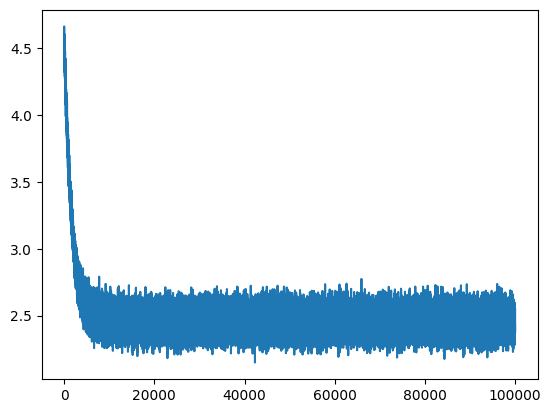

In [69]:
print(losses[0].item())
x_axis = [i for i in range(len(losses))]
y_axis = [losses[i].item() for i in range(len(losses))]
plt.plot(x_axis, y_axis)
plt.show()

In [ ]:
# Rnn model

In [ ]:
# transformer

In [11]:
# the actual main training loop

We are using device: cuda
